In [1]:
import matplotlib.pyplot as plt
import pandas as pd

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.
File descriptions

    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    sample_submission.csv - a sample submission file in the correct format.
    items.csv - supplemental information about the items/products.
    item_categories.csv  - supplemental information about the items categories.
    shops.csv- supplemental information about the shops.

Data fields

    ID - an Id that represents a (Shop, Item) tuple within the test set
    shop_id - unique identifier of a shop
    item_id - unique identifier of a product
    item_category_id - unique identifier of item category
    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    item_price - current price of an item
    date - date in format dd/mm/yyyy
    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    item_name - name of item
    shop_name - name of shop
    item_category_name - name of item category

This dataset is permitted to be used for any purpose, including commercial use.


In [28]:
from datetime import datetime

sales = pd.read_csv("data/source/sales_train.csv")
sales["date"] = sales["date"].apply(lambda x: datetime.strptime(x, "%d.%m.%Y"))
display(sales.head(5))
sales.shape

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


(2935849, 6)

In [26]:
from datetime import datetime, timedelta

min_date = sales.date.min()
max_date = sales.date.max()
delta = (max_date - min_date).days

print(f"Number individual dates: {delta}")

def plot_series_daily(series):
    date_range = [min_date + timedelta(days=d) for d in range(delta + 1)]
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    
    a = [series[series.date == d].item_cnt_day.values for d in date_range]
    a = [x[0] if len(x) == 1 else 0 for x in a]
    
    ax.plot(
        date_range, 
        a,
        marker="o", 
        linestyle="--"
    );

Number individual dates: 1033


shop_id: 53, item_id: 10077


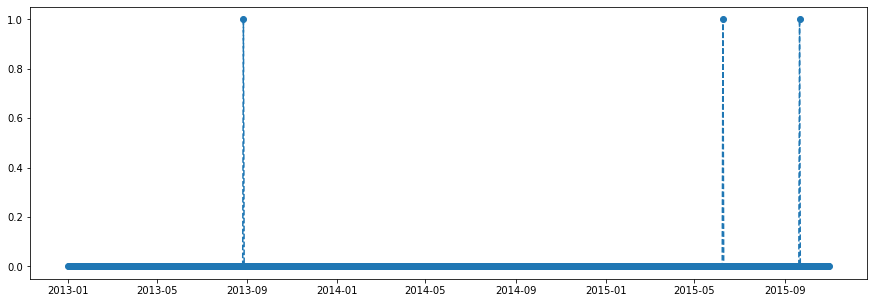

In [5]:
"""Randomly sample a timeseries for a shop, item"""

shop_item = sales.sample(n=1)[["shop_id", "item_id"]].values[0]
print(f"shop_id: {shop_item[0]}, item_id: {shop_item[1]}")

example_ts = sales.query(f"shop_id == {shop_item[0]} and item_id == {shop_item[1]}").sort_values("date")

plot_series_daily(example_ts)

In [6]:
""" Aggregated data per item and shop"""

sales_per_item = sales.groupby(["date", "date_block_num", "item_id"]).agg({
    "item_price": "mean",
    "item_cnt_day": "sum"
}).reset_index()

sales_per_item

,date,date_block_num,item_id,item_price,item_cnt_day
0,2013-01-01,0,32,348.906667,7.0
1,2013-01-01,0,33,499.000000,2.0
2,2013-01-01,0,53,170.000000,1.0
3,2013-01-01,0,59,179.500000,2.0
4,2013-01-01,0,85,299.000000,1.0
...,...,...,...,...,...
1541609,2015-10-31,33,22102,1250.000000,6.0
1541610,2015-10-31,33,22118,98.000000,1.0
1541611,2015-10-31,33,22139,399.000000,1.0
1541612,2015-10-31,33,22145,199.000000,1.0


In [7]:
sales_per_shop = sales.groupby(["date", "date_block_num", "shop_id"]).agg({
    "item_price": "sum",
    "item_cnt_day": "sum"
}).reset_index()

sales_per_shop

,date,date_block_num,shop_id,item_price,item_cnt_day
0,2013-01-01,0,2,31287.0,24.0
1,2013-01-01,0,7,58595.0,89.0
2,2013-01-01,0,8,43118.0,50.0
3,2013-01-01,0,13,5804.0,31.0
4,2013-01-01,0,14,43673.0,66.0
...,...,...,...,...,...
47223,2015-10-31,33,55,38268.0,137.0
47224,2015-10-31,33,56,48622.0,67.0
47225,2015-10-31,33,57,105070.0,121.0
47226,2015-10-31,33,58,85774.0,82.0


item_id: 4085


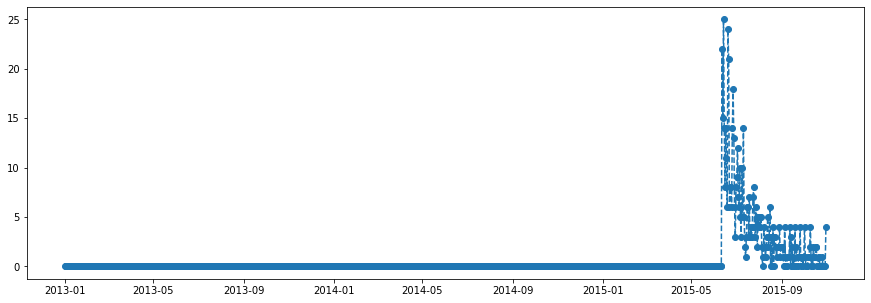

In [8]:
"""Randomly sample a timeseries for an item aggregated over all shops"""

item = sales_per_item.sample(n=1)[["item_id"]].values[0][0]
print(f"item_id: {item}")

example_ts = sales_per_item.query(f"item_id == {item}").sort_values("date")

plot_series_daily(example_ts)

shop_id: 5


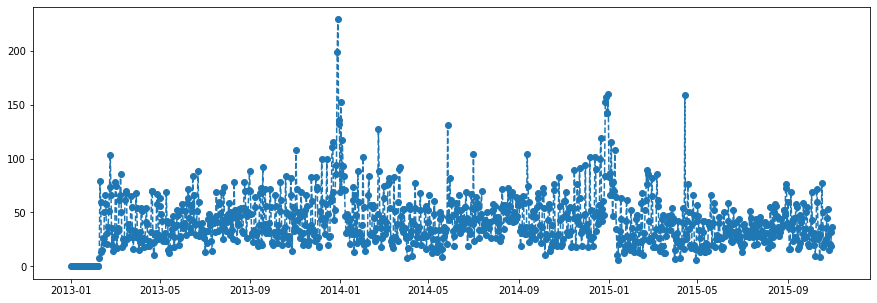

In [9]:
"""Randomly sample a timeseries for a shop aggregated over all items"""

shop = sales_per_shop.sample(n=1)[["shop_id"]].values[0][0]
print(f"shop_id: {shop}")

example_ts = sales_per_shop.query(f"shop_id == {shop}").sort_values("date")

plot_series_daily(example_ts)

In [10]:
"""montly data"""

sales_monthly = sales.groupby(["date_block_num", "shop_id", "item_id"]).agg({
    "item_price": "mean",
    "item_cnt_day": "sum"
}).reset_index().rename(columns={"item_cnt_day": "item_cnt_month"})

sales_per_item_monthly = sales_per_item.groupby(["date_block_num", "item_id"]).agg({
    "item_price": "mean",
    "item_cnt_day": "sum"
}).reset_index().rename(columns={"item_cnt_day": "item_cnt_month"})

sales_per_shop_monthly = sales_per_shop.groupby(["date_block_num", "shop_id"]).agg({
    "item_price": "sum",
    "item_cnt_day": "sum"
}).reset_index().rename(columns={"item_cnt_day": "item_cnt_month"})

In [11]:
sales_per_shop_monthly

,date_block_num,shop_id,item_price,item_cnt_month
0,0,0,2.546339e+06,5578.0
1,0,1,1.378736e+06,2947.0
2,0,2,1.028861e+06,1146.0
3,0,3,5.500130e+05,767.0
4,0,4,1.330204e+06,2114.0
...,...,...,...,...
1581,33,55,1.032017e+06,1972.0
1582,33,56,1.269425e+06,1263.0
1583,33,57,2.224367e+06,2316.0
1584,33,58,1.609430e+06,1446.0


In [12]:
def plot_series_monthly(series):
    dateblock_range = list(range(34))
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    
    a = [series[series.date_block_num == d].item_cnt_month.values for d in dateblock_range]
    a = [x[0] if len(x) == 1 else 0 for x in a]
    
    ax.plot(
        dateblock_range, 
        a,
        marker="o", 
        linestyle="--"
    )
    
    for v in [9, 21, 33]:
        ax.axvline(v, color="gray", linestyle="--");

shop_id: 54, item_id: 17157


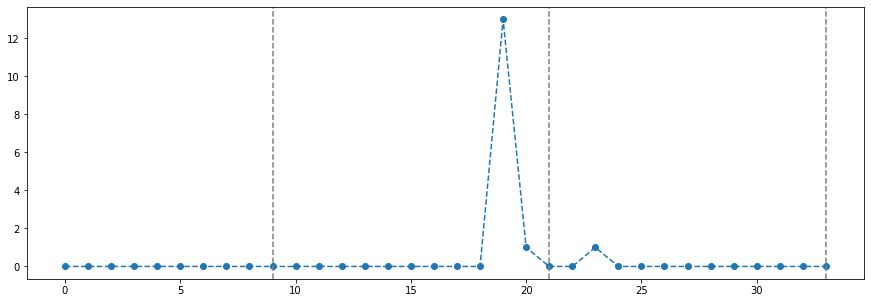

In [13]:
"""Randomly sample a monthly timeseries for a shop, item"""

shop_item = sales_monthly.sample(n=1)[["shop_id", "item_id"]].values[0]
print(f"shop_id: {shop_item[0]}, item_id: {shop_item[1]}")

example_ts = sales_monthly.query(
    f"shop_id == {shop_item[0]} and item_id == {shop_item[1]}"
).sort_values("date_block_num")

plot_series_monthly(example_ts)

item_id: [7963]


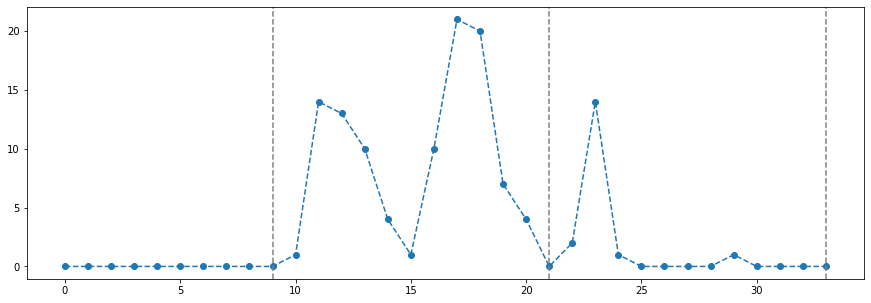

In [14]:
"""Randomly sample a monthly timeseries for an item"""

item = sales_per_item_monthly.sample(n=1)[["item_id"]].values[0]
print(f"item_id: {item}")

example_ts = sales_per_item_monthly.query(
    f"item_id == {item}"
).sort_values("date_block_num")

plot_series_monthly(example_ts)

shop_id: 57


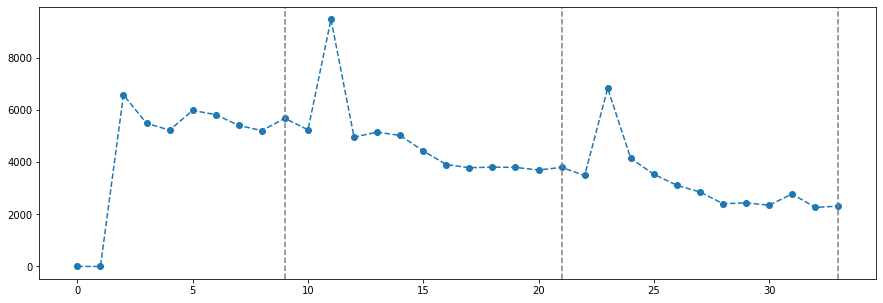

In [15]:
"""Randomly sample a monthly timeseries for a shop"""

shop = sales_per_shop_monthly.sample(n=1)[["shop_id"]].values[0][0]
print(f"shop_id: {shop}")

example_ts = sales_per_shop_monthly.query(
    f"shop_id == {shop}"
).sort_values("date_block_num")

plot_series_monthly(example_ts)

In [16]:
sales_monthly.sort_values(by="item_cnt_month", ascending=False)

,date_block_num,shop_id,item_id,item_price,item_cnt_month
1582127,33,12,11373,382.224936,2253.0
1574410,32,55,9249,1506.993991,1644.0
1552020,32,12,9248,1508.318762,1644.0
657943,11,31,20949,4.998710,1305.0
1412964,27,55,3730,1998.764706,1242.0
...,...,...,...,...,...
575694,10,12,3732,2534.000000,-4.0
1026259,19,12,11367,291.666667,-5.0
11047,0,12,1593,1799.000000,-6.0
11045,0,12,1590,2599.000000,-13.0


In [17]:
sales_per_item_monthly.sort_values(by="item_cnt_month", ascending=False)

,date_block_num,item_id,item_price,item_cnt_month
98088,11,20949,4.875107,12557.0
178375,23,20949,4.939320,12185.0
89615,10,20949,4.880248,8537.0
49152,5,20949,4.889355,8424.0
73513,8,20949,4.866964,7945.0
...,...,...,...,...
113793,14,2331,2799.000000,-3.0
150209,19,11367,291.666667,-5.0
409,0,1590,2599.000000,-12.0
106674,13,2331,2783.368421,-18.0


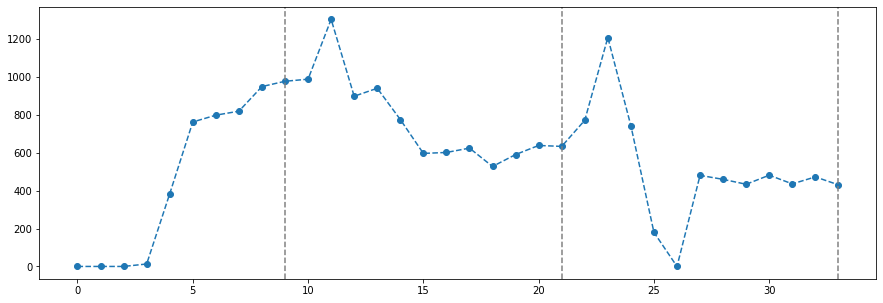

In [18]:
example_ts = sales_monthly.query(
    f"shop_id == 31 and item_id == 20949"
).sort_values("date_block_num")

plot_series_monthly(example_ts)

# Other stuff

In [19]:
pd.read_csv("data/source/items.csv")

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [20]:
pd.read_csv("data/source/item_categories.csv")

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [21]:
pd.read_csv("data/source/shops.csv").head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [22]:
test = pd.read_csv("data/source/test.csv")
test.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [23]:
test.groupby("shop_id").count()

,ID,item_id
shop_id,,
2,5100,5100
3,5100,5100
4,5100,5100
5,5100,5100
6,5100,5100
7,5100,5100
10,5100,5100
12,5100,5100
14,5100,5100


In [24]:
pd.read_csv("data/source/sample_submission.csv").head(5)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
